In [1]:
cd

/home/athurai3


In [2]:
import nibabel as nib
import numpy as np
from skimage.measure import label, regionprops, regionprops_table
import matplotlib as plt
from nilearn import plotting
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd
from skimage import morphology
from skimage import measure

In [3]:
ct_img_path = 'scratch/test_noninterp_image/sub-P001/sub-P001_desc-rigid_space-T1w_ct.nii.gz'
ct_img = nib.load(ct_img_path)
ct_img_data = ct_img.get_fdata()

In [4]:
def df_to_fcsv(input_df, output_fcsv):
	with open(output_fcsv, 'w') as fid:
		fid.write("# Markups fiducial file version = 4.11\n")
		fid.write("# CoordinateSystem = 0\n")
		fid.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n")
	
	out_df={'node_id':[],'x':[],'y':[],'z':[],'ow':[],'ox':[],'oy':[],'oz':[],
		'vis':[],'sel':[],'lock':[],'label':[],'description':[],'associatedNodeID':[]
	}
	
	for idx,ifid in input_df.iterrows():
		out_df['node_id'].append(idx+1)
		out_df['x'].append(ifid[0])
		out_df['y'].append(ifid[1])
		out_df['z'].append(ifid[2])
		out_df['ow'].append(0)
		out_df['ox'].append(0)
		out_df['oy'].append(0)
		out_df['oz'].append(0)
		out_df['vis'].append(1)
		out_df['sel'].append(1)
		out_df['lock'].append(1)
		out_df['label'].append(str(ifid[3]))
		out_df['description'].append('')
		out_df['associatedNodeID'].append('')

	out_df=pd.DataFrame(out_df)
	out_df.to_csv(output_fcsv, sep=',', index=False, lineterminator="", mode='a', header=False, float_format = '%.3f')

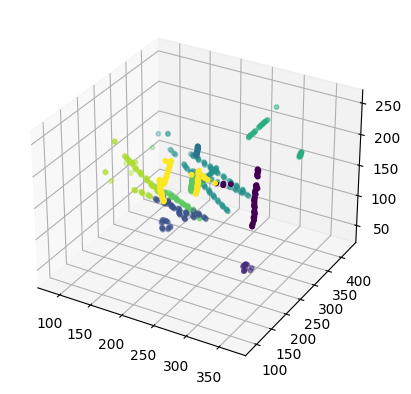

In [5]:
def find_markers(img_data, threshold):
	final_location = pd.DataFrame([])
	for slice_idx in range(img_data.shape[2]):
		slice_img = img_data[:,:,slice_idx]
		
		# threshold the image
		thresh_img = np.where(slice_img<threshold,1.0,0.0)
		eroded = morphology.erosion(thresh_img, np.ones([3,3]))
		contours = measure.find_contours(eroded, 0.3)
		
		final_loc = []
		for contour in contours:
			# find xy coordinates in contour blob
			left = tuple([contour[contour[:,0].argmin()][0], contour[contour[:,0].argmin()][1]])
			right = tuple([contour[contour[:,0].argmax()][0], contour[contour[:,0].argmax()][1]])
			
			centx = int(np.sqrt(((right[0] + left[0])**2)/4))
			centy = int(np.sqrt(((right[1] + left[1])**2)/4 ))
			if np.all([slice_img[centx,centy] > threshold, contour.shape[0] < 40]):
				final_loc.append([centx, centy, slice_idx,slice_img[centx,centy]])
		
		if final_loc:
			final_location = pd.concat([final_location, pd.DataFrame(final_loc)], axis = 0, ignore_index=True)
	
	final_location = np.c_[final_location.iloc[:,0].values, final_location.iloc[:,1].values, final_location.iloc[:,2].values]
	
	return final_location


class cluster():
	
	def __init__(self, pcd_list=None, method=None, n_clusters = None):
		self.pcd_list = pcd_list
		
		method_dic={
			"kmeans":{
				'method': KMeans,
				'options':{
					'init':'random',
					'n_clusters': n_clusters if n_clusters is not None else 10,
					#'n_jobs':3,
					'n_init':10
					}
				},
			"affinity":{
				'method': AffinityPropagation,
				'options':{
					'preference':-1
					}
				},
			"dbscan":{
				'method': DBSCAN,
				'options':{
					'eps':0.0001
					}
				},
			"agglomerative":{
                'method': AgglomerativeClustering,
                'options':{
					'n_clusters': n_clusters if n_clusters is not None else 10,
                    }
                }
        }
		self.method = method_dic[method]
		
	def clusterData(self):
		"""
		Take an input array of 3D points (x,y,z) and cluster based on the desired method.
		pcd_list is a list of points
		method_str is a string describing the method to use to cluster
		options is the options dictionary used by some scikit clustering
		functions
		"""
		
		# Keep two dimensions only to compute cluster (remove elevation)
		pcd_list = np.array(self.pcd_list)[:,:2]
	
		# Build the estimator with the given options
		estimator =self.method['method'](**self.method['options'])
	
		# Fit the estimator
		estimator.fit(self.pcd_list)
	
		# Get the labels and return the labeled points
		labels = estimator.labels_
		self.clusters = np.append(self.pcd_list, np.array([labels]).T, 1)
	
		return self.clusters

	def getCluster(self, i):
		"""
		Return the points belonging to a given cluster.
		clusters: list of labeled points where labels are the cluster ids
		i: id of the cluster to get
		label_field: field where the cluster id is stored in the list of labeled
		points
		"""
		return [c.tolist() for c in self.clusters if c[2] == i]

	def clustersSize(self):
		"""
		Return the size of the clusters given a list of labeled points.
		"""
		from collections import Counter
		
		labels = self.clusters[:,2]
		counter = Counter(labels)
		
		return counter.most_common()

#%%

#filen = r'/home/greydon/Documents/GitHub/seeg2bids-pipeline/resources/sub-P221_ses-post_acq-DBS_ct.nii.gz'
#filen = r'/media/veracrypt6/projects/iEEG/working_dir/out/results/sub-049/sub-049_desc-masked_from-atropos3seg_ct.nii.gz'

# threshold for CT
threshold = 2100

#img = nib.load(filen)
#img_data = img.get_fdata()

# extract cluster blobs above threshold
final_location = find_markers(ct_img_data, threshold)


# cluster the points (mthod can be: kmeans, affinity, dbscan)
clust = cluster(final_location, method="kmeans", n_clusters=9)
clusters = clust.clusterData()


# plot the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*clusters[:,0:3].T, s=10, c=clusters[:,3])

In [7]:
final_location.shape

(634, 3)

In [8]:
ct_img_data.shape

(512, 512, 256)

In [9]:
print(clusters[0])

[197 323  61   5]


In [10]:
df = pd.DataFrame(clusters)

In [11]:
df_clustering_method = df

In [12]:
df_clustering_method.rename(columns={0:'x', 1:'y', 2:'z', 3:'cluster_label'}, inplace = True)
df_clustering_method.sort_values('cluster_label', inplace = True)
df_clustering_method

,x,y,z,cluster_label
504,240,222,220,0
591,250,206,241,0
593,250,205,242,0
550,246,213,232,0
544,245,214,231,0
...,...,...,...,...
74,204,393,89,8
73,203,355,89,8
314,202,339,127,8
154,178,382,102,8


In [13]:
ct_aff = ct_img.get_qform()
ct_aff

array([[-4.70829924e-01,  2.49257970e-02,  1.62494750e-01,
         9.30704117e+01],
       [ 3.36728871e-03,  4.81331693e-01, -1.04983498e-01,
        -7.11374817e+01],
       [ 1.29328987e-01,  7.82116106e-02,  5.94305286e-01,
        -1.00006012e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [14]:
ct_img.affine

array([[-4.70830023e-01,  2.49258187e-02,  1.62494689e-01,
         9.30704117e+01],
       [ 3.36733554e-03,  4.81331676e-01, -1.04983278e-01,
        -7.11374817e+01],
       [ 1.29328653e-01,  7.82117769e-02,  5.94305336e-01,
        -1.00006012e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [15]:
df_clustering_method.drop('cluster_label', axis = 1).shape

(634, 3)

In [16]:
coords = df_clustering_method[['x', 'y', 'z']].to_numpy()
coords[0, :]

array([240, 222, 220])

In [17]:
M = ct_img.affine[:3,:3]
abc = ct_img.affine[:3,3]
def voxel_scanner(i, j, k):
    return M.dot([i, j, k]) + abc

transformed_coords = np.zeros(coords.shape)
for i in range(len(transformed_coords)):
    vec = coords[i,:]
    tvec = M.dot(vec) + abc
    transformed_coords[i,:] = tvec[:3]
transformed_coords

array([[ 21.35356947,  13.42998989,  79.14305331],
       [ 19.65884461,   3.55770759,  91.66536348],
       [ 19.79641348,   2.97139264,  92.18145704],
       ...,
       [ 27.04942504,  79.38128208,  28.10894609],
       [ 35.35878857, 102.62231004,  13.51053141],
       [ 36.82303775,  90.6403147 ,  13.62268415]])

In [18]:
tcoords = np.zeros(coords.shape)

for i in range(len(tcoords)):
    vec = np.hstack([coords[i,:],1])
    tvec =  ct_img.affine @ vec.T
    tcoords[i,:] = tvec[:3]
tcoords

array([[ 21.35356947,  13.42998989,  79.14305331],
       [ 19.65884461,   3.55770759,  91.66536348],
       [ 19.79641348,   2.97139264,  92.18145704],
       ...,
       [ 27.04942504,  79.38128208,  28.10894609],
       [ 35.35878857, 102.62231004,  13.51053141],
       [ 36.82303775,  90.6403147 ,  13.62268415]])

In [19]:
aff_points = pd.DataFrame(transformed_coords, columns = ['x','y','z'])
aff_points

,x,y,z
0,21.353569,13.429990,79.143053
1,19.658845,3.557708,91.665363
2,19.796413,2.971393,92.181457
3,20.254193,7.858409,86.346783
4,20.587454,8.441357,85.701361
...,...,...,...
629,21.278961,109.369292,10.007437
630,20.802610,91.075321,6.906060
631,27.049425,79.381282,28.108946
632,35.358789,102.622310,13.510531


In [20]:
aff_points['label'] = df_clustering_method['cluster_label'].reset_index(drop = True)
aff_points

,x,y,z,label
0,21.353569,13.429990,79.143053,0
1,19.658845,3.557708,91.665363,0
2,19.796413,2.971393,92.181457,0
3,20.254193,7.858409,86.346783,0
4,20.587454,8.441357,85.701361,0
...,...,...,...,...
629,21.278961,109.369292,10.007437,8
630,20.802610,91.075321,6.906060,8
631,27.049425,79.381282,28.108946,8
632,35.358789,102.622310,13.510531,8


In [22]:
df_to_fcsv(aff_points, 'scratch/clustering_approach/sub-P001/sub-P001_desc-kmeans_9clusters_contacts.fcsv')

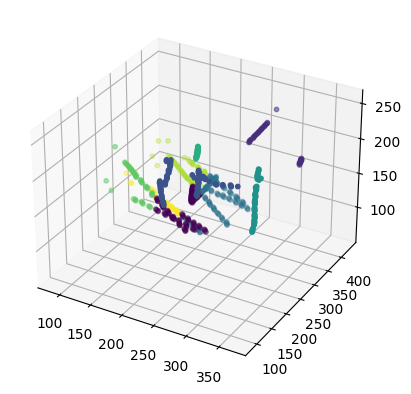

In [24]:
# extract cluster blobs above threshold
final_location = find_markers(ct_img_data, threshold)


# cluster the points (mthod can be: kmeans, affinity, dbscan)
clust = cluster(final_location, method= "agglomerative", n_clusters=9)
clusters = clust.clusterData()

#create dataframe of x,y,z coords for clusters in voxel space
df = pd.DataFrame(clusters)
df.rename(columns={0:'x', 1:'y', 2:'z', 3:'cluster_label'}, inplace = True)
df.sort_values('cluster_label', inplace = True)

#convert to numpy array, to transform to scanner/RAS space
coords = df[['x', 'y', 'z']].to_numpy()

#take zooms/translations from image affine
M = ct_img.affine[:3,:3]
abc = ct_img.affine[:3,3]

#create empty array to fill with transformed coordinates
transformed_coords = np.zeros(coords.shape)
#apply tranformations row by row
for i in range(len(transformed_coords)):
    vec = coords[i,:]
    tvec = M.dot(vec) + abc
    transformed_coords[i,:] = tvec[:3]

#create new df of transformed points
ras_points = pd.DataFrame(transformed_coords, columns = ['x','y','z'])
ras_points['label'] = df_clustering_method['cluster_label'].reset_index(drop = True)
df_to_fcsv(aff_points, 'scratch/clustering_approach/sub-P001/sub-P001_desc-agg_9clusters_contacts.fcsv')

#plot the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*clusters[:,0:3].T, s=10, c=clusters[:,3])


In [6]:
thresh_ct = np.where(ct_img_data>threshold,1.0,0.0)
label_thresh = label((thresh_ct).astype(int))


pointlist_thresh={
    'x':[],
    'y':[],
    'z':[],
    'labels':[],
}

for regions in regionprops(label_thresh):
    pointlist_thresh['x'].append(regions.centroid[0])
    pointlist_thresh['y'].append(regions.centroid[1])
    pointlist_thresh['z'].append(regions.centroid[2])
    pointlist_thresh['labels'].append(regions.label)

pointlist_thresh = pd.DataFrame(pointlist_thresh)
pointlist_thresh

,x,y,z,labels
0,99.019970,301.448595,119.833580,1
1,100.926084,237.396944,134.292822,2
2,120.209541,320.999487,104.770967,3
3,104.588172,251.532636,175.621709,4
4,120.963711,359.375513,127.473651,5
...,...,...,...,...
100,365.712329,140.547945,212.150685,101
101,367.743243,136.216216,204.689189,102
102,366.500000,155.000000,232.000000,103
103,369.026667,132.120000,197.466667,104


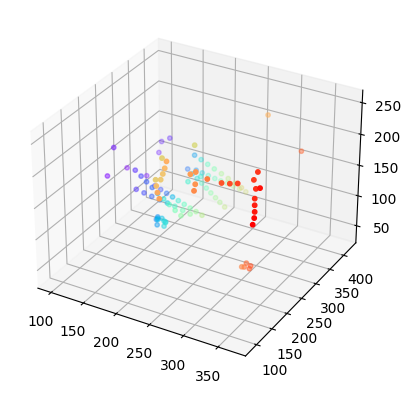

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointlist_thresh['x'], pointlist_thresh['y'], pointlist_thresh['z'], c = pointlist_thresh['labels'], cmap = 'rainbow', s = 10)

In [9]:
clusterer_kmeans = KMeans(n_clusters = 9)
clusterer_kmeans.fit(pointlist_thresh.drop('labels', axis = 1))
pointlist_thresh['kmeans_labels'] = clusterer_kmeans.labels_
pointlist_thresh.drop('labels', axis = 1, inplace = True)

/local/athurai3.16244022.0/tmp/kslurm-venv-dltn7_7l/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
pointlist_thresh.sort_values(by = ['kmeans_labels'], inplace = True)
pointlist_thresh

,x,y,z,kmeans_labels
0,99.019970,301.448595,119.833580,0
2,120.209541,320.999487,104.770967,0
4,120.963711,359.375513,127.473651,0
5,122.273802,365.808027,143.462974,0
6,136.056835,364.456475,153.636331,0
...,...,...,...,...
47,193.186047,291.569767,92.534884,8
22,172.140351,247.929825,71.385965,8
45,190.826087,248.666667,110.434783,8
53,202.654762,290.797619,89.714286,8


In [15]:
coords = pointlist_thresh[['x', 'y', 'z']].to_numpy()

#take zooms/translations from image affine
M = ct_img.affine[:3,:3]
abc = ct_img.affine[:3,3]

#create empty array to fill with transformed coordinates
transformed_coords = np.zeros(coords.shape)
#apply tranformations row by row
for i in range(len(transformed_coords)):
    vec = coords[i,:]
    tvec = M.dot(vec) + abc
    transformed_coords[i,:] = tvec[:3]

#create new df of transformed points
ras_points = pd.DataFrame(transformed_coords, columns = ['x','y','z'])
ras_points['kmeans_label'] = pointlist_thresh['kmeans_labels'].reset_index(drop = True)
df_to_fcsv(ras_points, 'scratch/clustering_approach/sub-P001/sub-P001_desc-label_kmeans_clusters_contacts.fcsv')

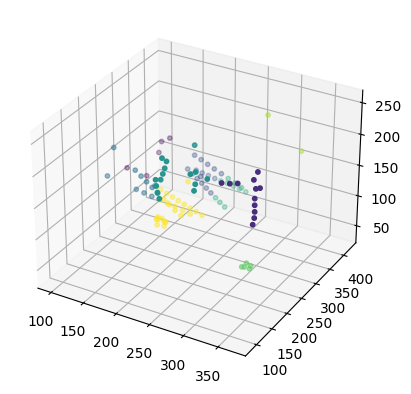

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointlist_thresh['x'], pointlist_thresh['y'], pointlist_thresh['z'], c = pointlist_thresh['kmeans_labels'], s = 10)

In [13]:
ct_img.aff

AttributeError: 'Nifti1Image' object has no attribute 'aff'

In [ ]:
test_out = pd.read_csv('projects/ctb-akhanf/athurai3/unet_contact_seg/keras_implementation/kmeans_electrodes_test.fcsv', sep=',',header=2)
test_out

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection = '3d')
ax2.scatter(seega_out['x'], seega_out['y'], seega_out['z'], c = range(90), cmap = 'rainbow')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig2.show()

In [ ]:
def df_to_fcsv(input_df, output_fcsv):
	with open(output_fcsv, 'w') as fid:
		fid.write("# Markups fiducial file version = 4.11\n")
		fid.write("# CoordinateSystem = 0\n")
		fid.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n")
	
	out_df={'node_id':[],'x':[],'y':[],'z':[],'ow':[],'ox':[],'oy':[],'oz':[],
		'vis':[],'sel':[],'lock':[],'label':[],'description':[],'associatedNodeID':[]
	}
	
	for idx,ifid in input_df.iterrows():
		out_df['node_id'].append(idx+1)
		out_df['x'].append(ifid[0])
		out_df['y'].append(ifid[1])
		out_df['z'].append(ifid[2])
		out_df['ow'].append(0)
		out_df['ox'].append(0)
		out_df['oy'].append(0)
		out_df['oz'].append(0)
		out_df['vis'].append(1)
		out_df['sel'].append(1)
		out_df['lock'].append(1)
		out_df['label'].append(str(ifid[4]))
		out_df['description'].append('')
		out_df['associatedNodeID'].append('')

	out_df=pd.DataFrame(out_df)
	out_df.to_csv(output_fcsv, sep=',', index=False, lineterminator="", mode='a', header=False, float_format = '%.3f')
df_to_fcsv(pointlist_thresh.sort_values(by = ['kmeans_labels']), 'projects/ctb-akhanf/athurai3/unet_contact_seg/keras_implementation/kmeans_electrodes_test.fcsv')